In [6]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from pywt import wavedec
from scipy.signal import find_peaks
from scipy.stats import median_absolute_deviation
from sklearn.linear_model import lars_path

from Scripts.debiasing import debiasing_int, debiasing
from Scripts.fista_update import fista_update as fista
from Scripts.hrf_matrix import HRFMatrix
from Scripts.temporal_ta import filter_boundary as ta_filter
from Scripts.total_activation import total_activation as ta
from Scripts.total_activation import hrf_filters
from Scripts.simulate import fMRIsim
from Scripts.stability_selection import stability_selection

In [39]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 22,
         'axes.labelsize': 22,
         'axes.titlesize': 22,
         'xtick.labelsize': 22,
         'ytick.labelsize': 22}
pylab.rcParams.update(params)

In [48]:
nscans = 260
params = {'tr': 0.1, 'cost_save': True, 'te': [0]} # This is for TA (to follow MATLAB code structure)
# Generate design matrix (shifted HRFs) for PFM with the spike model
hrf_matrix_01 = HRFMatrix(TR=params['tr'], TE=params['te'], nscans=nscans, r2only=True, has_integrator=False, is_afni=True, lop_hrf='SPMG1')
hrf_matrix_01.generate_hrf()
hrf_SPMG1_01 = hrf_matrix_01.X_hrf_norm

# Generate hrf filter for TA with spike model
params['model'] = 'spike'
params['f_analyze'], params['f_recons'], params['maxeig'] = hrf_filters(params['tr'], condition=params['model'], condition2='spmhrf')
n = params['f_recons']['den'][0]
d = [np.array(params['f_recons']['num']), 1]

test_data_01 = np.zeros(nscans)
test_data_01[int(0/params['tr'])] = 1

bold_pfm_01 = np.dot(hrf_SPMG1_01, test_data_01)
bold_ta_01 = np.real(ta_filter(n, d, test_data_01.T, 'normal', nscans))

time_01 = np.linspace(0, nscans*0.1, nscans)
time_idx_01 = np.where(time_01 >= 24)[0][0]

# Generate design matrix (shifted HRFs) for PFM with the spike model
hrf_matrix_2 = HRFMatrix(TR=2, TE=params['te'], nscans=nscans, r2only=True, has_integrator=False, is_afni=True, lop_hrf='SPMG1')
hrf_matrix_2.generate_hrf()
hrf_SPMG1_2 = hrf_matrix_2.X_hrf_norm

# Generate hrf filter for TA with spike model
params = {'tr': 2, 'cost_save': True, 'te': [0]} # This is for TA (to follow MATLAB code structure)
params['model'] = 'spike'
params['f_analyze'], params['f_recons'], params['maxeig'] = hrf_filters(params['tr'], condition=params['model'], condition2='spmhrf')
n = params['f_recons']['den'][0]
d = [np.array(params['f_recons']['num']), 1]

test_data_2 = np.zeros(nscans)
test_data_2[int(0/params['tr'])] = 1

bold_pfm_2 = np.dot(hrf_SPMG1_2, test_data_2)
bold_ta_2 = np.real(ta_filter(n, d, test_data_2.T, 'normal', nscans))

time_2 = np.linspace(0, nscans*2, nscans)
time_idx_2 = np.where(time_2 >= 25)[0][0]


Duration of HRF was not sufficient for specified model. Doubling duration and computing again.
Duration of HRF was not sufficient for specified model. Doubling duration and computing again.
Duration of HRF was not sufficient for specified model. Doubling duration and computing again.
Duration of HRF was not sufficient for specified model. Doubling duration and computing again.


/Users/enekourunuela/pfm_vs_ta/code/Scripts/total_activation.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  fil[i + 1] = (-1) ** (i + 1) * np.sum(np.exp(np.sum(combs_result, axis=1)))


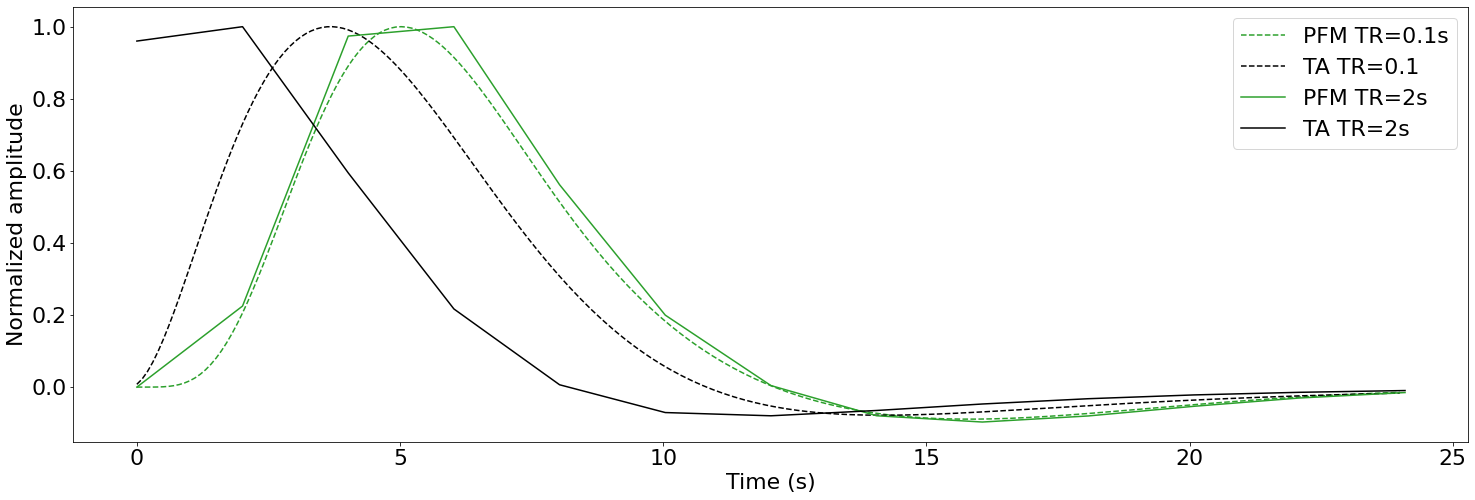

In [49]:
plt.figure(figsize=(25,8))
plt.plot(time_01[:time_idx_01], bold_pfm_01[:time_idx_01]/np.max(bold_pfm_01[:time_idx_01]), label='PFM TR=0.1s', color='tab:green', linestyle="--")
plt.plot(time_01[:time_idx_01], bold_ta_01[:time_idx_01]/np.max(bold_ta_01[:time_idx_01]), label='TA TR=0.1', color='black', linestyle="--")
plt.plot(time_2[:time_idx_2], bold_pfm_2[:time_idx_2]/np.max(bold_pfm_2[:time_idx_2]), label='PFM TR=2s', color='tab:green')
plt.plot(time_2[:time_idx_2], bold_ta_2[:time_idx_2]/np.max(bold_ta_2[:time_idx_2]), label='TA TR=2s', color='black')
plt.xlabel('Time (s)')
plt.ylabel('Normalized amplitude')
plt.legend()

In [50]:
params = {'tr': 2, 'cost_save': True, 'te': [0]} # This is for TA (to follow MATLAB code structure)
params['model'] = 'spike'
params['f_analyze'], params['f_recons'], params['maxeig'] = hrf_filters(params['tr'], condition=params['model'], condition2='spmhrf')
n = params['f_recons']['den'][0]
d = [np.array(params['f_recons']['num']), 1]

test_data = np.zeros(nscans)
test_data[int(0/params['tr'])] = 1

# Generate design matrix (shifted HRFs) for PFM with the spike model
hrf_matrix = HRFMatrix(TR=params['tr'], TE=params['te'], nscans=nscans, r2only=True, has_integrator=False, is_afni=True, lop_hrf='SPMG1')
hrf_matrix.generate_hrf()
hrf = hrf_matrix.X_hrf_norm

# Generate hrf filter for TA with spike model
params['model'] = 'spike'
params['f_analyze'], params['f_recons'], params['maxeig'] = hrf_filters(params['tr'], condition=params['model'], condition2='spmhrf')
n = params['f_recons']['den'][0]
d = [np.array(params['f_recons']['num']), 1]

bold_pfm = np.dot(hrf, test_data)
bold_ta = np.real(ta_filter(n, d, test_data.T, 'normal', nscans))

append_2 = 2*nscans - len(bold_ta)
temp = np.append(bold_ta, np.zeros(append_2))
for i in range(nscans-1):
    foo = np.append(np.zeros(i+1), bold_ta)
    append_2 = 2*nscans - len(foo)
    foo = np.append(foo, np.zeros(append_2))
    temp = np.column_stack((temp, foo))

hrf = temp[:nscans, :nscans]

/Users/enekourunuela/pfm_vs_ta/code/Scripts/total_activation.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  fil[i + 1] = (-1) ** (i + 1) * np.sum(np.exp(np.sum(combs_result, axis=1)))


Text(0, 0.5, 'Normalized amplitude')

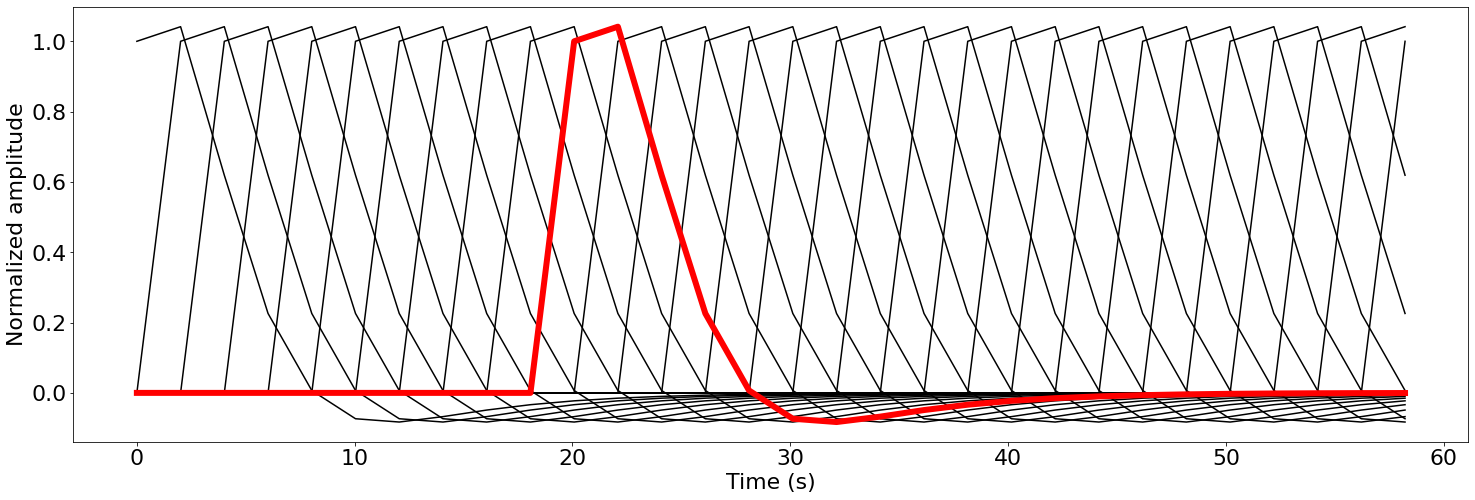

In [66]:
plt.figure(figsize=(25,8))

leng = 30
for i in range(leng):
    plt.plot(time_2[:leng], hrf[:leng,i], color='black')

    
plt.plot(time_2[:leng], hrf[:leng, 10], color='red', linewidth=6)
plt.xlabel('Time (s)')
plt.ylabel('Normalized amplitude')